# logistic regression

The building block for ANN

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) # z = theta@x
        
    def forward(self, x): # predict
        out = self.linear(x)
        return torch.sigmoid(out) # 1/(1+exp(-theta@x)

The `nn.Linear` module in PyTorch is used to apply a linear transformation to the incoming data, which is a fundamental operation in neural networks. This module is often referred to as a fully connected layer or dense layer.  

`logistic regression = linear regression + sigmoid activation`

自定义Dataset类

本例需要一个二分类数据集，使用sonar数据集。

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class SonarDataset(Dataset):
    def __init__(self, file_path='../data/sonarall-data.csv', header=None, transform=None, 
                 target_transform=None ):

        df=pd.read_csv(file_path, header = header)
       
        self.X=torch.tensor(df.iloc[:,:-1].values)
        label_ids = [['R', 'M'].index(x) for x in df.iloc[:,-1].values] # map string label to int
        self.y=torch.tensor(label_ids)

        self.transform = transform
        self.target_transform = target_transform

        # print(self.X)
        # print(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index
        """
        x = self.X[idx]
        label = self.y[idx]
        # print(idx, x, label)
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            label = self.target_transform(label)
        return x, label

In [4]:
dataset = SonarDataset()
print(dataset.X.shape, dataset.y.shape)

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

torch.Size([208, 60]) torch.Size([208])



(dot.exe:58192): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


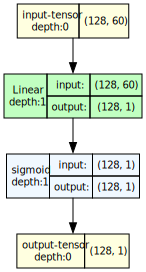

In [5]:
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LogisticRegression(input_dim = dataset.X.shape[1], output_dim = 1).to(device)

model_graph = draw_graph(model, input_size=(batch_size, dataset.X.shape[1]), expand_nested=True) # device='meta', 
model_graph.visual_graph

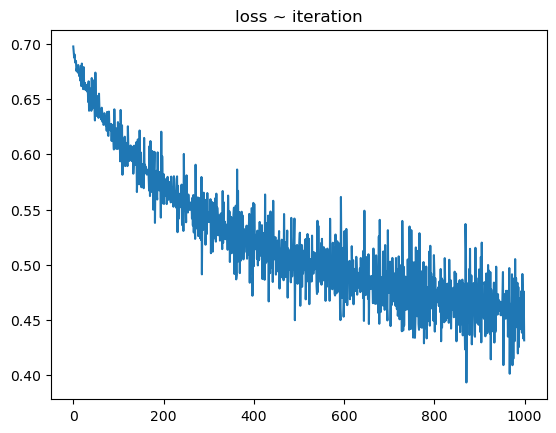

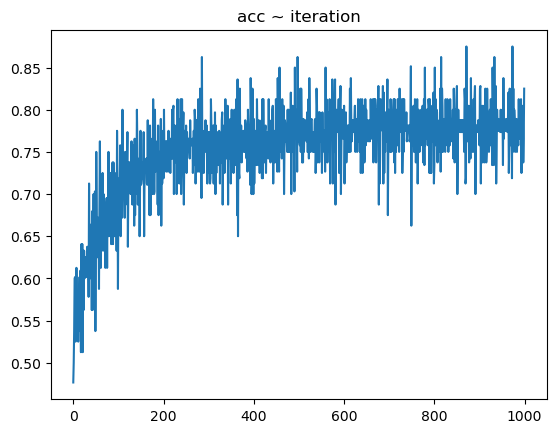

In [49]:
import matplotlib.pyplot as plt

model = LogisticRegression(input_dim = dataset.X.shape[1], output_dim = 1).to(device)
criterion = nn.BCELoss() # BCE = binary cross entropy 交叉熵
optimizer = torch.optim.SGD(model.parameters(), lr=.1) # stochastic gradient descent 梯度下降
losses = []
accs = []

for epoch in range(500):
    for i, (x, y) in enumerate(dataloader):

        x = x.float().to(device)
        y = y.float().view(-1,1).to(device)
        
        # Forward pass
        y_pred = model(x)

        acc = torch.sum(y_pred.round() == y)/len(y)
        accs.append(acc.item())
        
        # Compute loss
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Reset gradients
        optimizer.zero_grad() 

plt.title('loss ~ iteration')
plt.plot(losses)
plt.show()

plt.title('acc ~ iteration')
plt.plot(accs)
plt.show()

In [50]:
x,y = next(iter(dataloader))

x = x.float().to(device)
y = y.float().view(-1,1).to(device)

# Forward pass
y_pred = model(x)
print(y.flatten())
print(y_pred.round().flatten())

tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 1.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
      

效果一般，可能原因：logistic regression模型的fitting power有限。可尝试更复杂的分类模型，e.g., MLP, RandomForest, TabNet